In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import glob
import os

In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['figure.dpi'] = 70

In [3]:
TRAIN_DATA_FILES = glob.glob("data/train*")
TEST_DATA_FILES = glob.glob("data/test*")

In [4]:
data_file = TRAIN_DATA_FILES[0]
filename = os.path.split(data_file)[1]
data = pd.read_csv(data_file, sep=' ', header=None)

X_data, y_data = data[[0, 1]], data[2]
X_data = X_data.values
y_data = y_data.values

# Linear discriminant analysis

This generative model is given by a Gaussian mixture: the labels $y$ follow a Bernoulli distribution of parameter $\pi\in[0,1]$, with the likelihood of an antecedent $x$ given $y$ being
$$
    x|y=i \sim \mathcal{N}(\mu_i, \Sigma)
$$
where $\Sigma \in \mathcal S^{++}(\mathbb R^2)$.

The maximum likelihood estimates of the parameters $(\pi, (\mu_i), \Sigma)$ are, denoting $\mathcal C_i = \{n : y_n = i\}$,
$$
\begin{aligned}
    \pi^* &= \frac{|\mathcal C_i|}{N}  \\
    \mu_i^* &= \frac{1}{|\mathcal C_i|}\sum_{n\in\mathcal C_i}x_n  \\
    \Sigma^* &= \frac{1}{n}\sum_{n=1}^N (x_n-\mu_{y_n})(x_n-\mu_{y_n})^T
\end{aligned}
$$

In [5]:
pi_bernouilli = np.mean(y_data == 1)

mus_ = [
    np.mean(X_data[y_data == 0], axis=0),
    np.mean(X_data[y_data == 1], axis=0),
]


cov_matrix_ = np.cov(X_data, rowvar=False)

precision_matrix_ = np.linalg.inv(cov_matrix_)

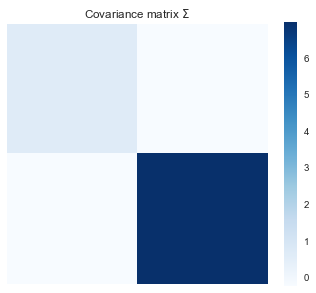

In [6]:
plt.imshow(cov_matrix_, extent=[0,1,0,1], cmap=cm.Blues)
plt.axis('off')
plt.colorbar()
plt.title("Covariance matrix $\\Sigma$");

In [7]:
def posterior_prob(x, pi, mus, prec):
    """Posterior probability."""
    dx0 = x - mus[0]
    dx1 = x - mus[1]
    c0 = pi * np.exp(-0.5 * np.dot(dx0, prec @ dx0))
    c1 = (1-pi) * np.exp(-0.5 * np.dot(dx1, prec @ dx1))
    return c1 / (c0 + c1)


In [8]:
## Define the line parameters
normal_vec = precision_matrix_ @ (mus_[1] - mus_[0])
renormed_vec = normal_vec / np.linalg.norm(normal_vec)
e = np.random.rand(2); e /= np.linalg.norm(e)
support_vec = e - np.dot(renormed_vec, e) * renormed_vec

renormed_vec.dot(support_vec)

mu_avg = 0.5 * (mus_[0] + mus_[1])

b_ = normal_vec @ mu_avg + np.log(pi_bernouilli / (1-pi_bernouilli))
b_ = np.array([b_])

base_point = np.linalg.lstsq(normal_vec[None], b_, rcond=None)[0]

line_points_ = [
    base_point + t * support_vec
    for t in [6, 63]
]

line_points_ = np.array(line_points_)

In [9]:
xlims_ = [X_data[:, 0].min(), X_data[:, 0].max()]
x_breadth = 0.6
xlims_[0] = xlims_[0] - x_breadth * (xlims_[1] - xlims_[0])
xlims_[1] = xlims_[1] + x_breadth * (xlims_[1] - xlims_[0])

ylims_ = [X_data[:, 1].min(), X_data[:, 1].max()]
y_breadth = 0.1
ylims_[0] = ylims_[0] - y_breadth * (ylims_[1] - ylims_[0])
ylims_[1] = ylims_[1] + y_breadth * (ylims_[1] - ylims_[0])

xar = np.linspace(*xlims_, 41)
yar = np.linspace(*ylims_, 51)

xg, yg = np.meshgrid(xar, yar)
grid_points_ = np.dstack((xg, yg))

grid_points_ = grid_points_.reshape(np.prod(xg.shape), 2)

postprob_grid = np.array([
    posterior_prob(x, pi_bernouilli, mus_, precision_matrix_)
    for x in grid_points_
])

postprob_grid = postprob_grid.reshape(*xg.shape)

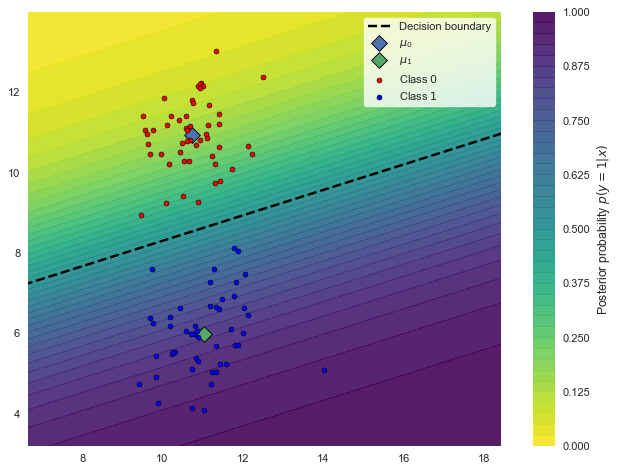

In [109]:
fig = plt.figure(figsize=(8, 6), dpi=80)

cf_ = plt.contourf(xg, yg, postprob_grid, levels=40,
                   zorder=-1, alpha=0.9,
                   cmap=cm.viridis_r)

cbar_ = fig.colorbar(cf_)
cbar_.set_label("Posterior probability $p(y=1|x)$")

## Add the class centroids
for i, mu in enumerate(mus_):
    plt.scatter(*mu, s=100, marker='D',
                edgecolors='k', linewidths=.8,
                label="$\\mu_{%d}$" % i)

plt.scatter(*X_data[y_data==0].T, s=20, edgecolors='k',
            c='r', linewidths=.5, label="Class $0$")

plt.scatter(*X_data[y_data==1].T, s=20, edgecolors='k',
            c='b', linewidths=.5, label="Class $1$")

plt.plot(*line_points_.T, c='k', lw=2.2, ls='--',
         label="Decision boundary")


legend_ = plt.legend(frameon=1)
frame_ = legend_.get_frame()
frame_.set_color('white')

plt.grid(False)
plt.axis('scaled')

plt.xlim(*xlims_)
plt.ylim(*ylims_)
fig.tight_layout();

In [110]:
fig.savefig("images/lda-pointcloud-decisionbound.pdf")

In [104]:
from scipy import stats

c0_prob = stats.multivariate_normal.pdf(
    grid_points_, mean=mus_[0], cov=cov_matrix_).reshape(*xg.shape)

c1_prob = stats.multivariate_normal.pdf(
    grid_points_, mean=mus_[1], cov=cov_matrix_).reshape(*xg.shape)

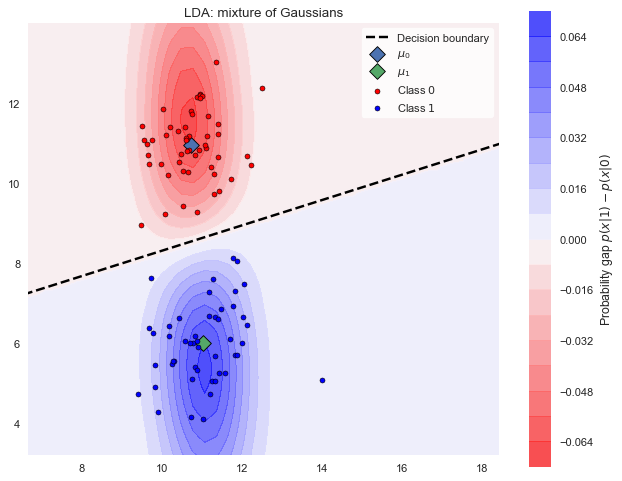

In [107]:
fig = plt.figure(figsize=(8, 6), dpi=80)

plt.contourf(xg, yg, c1_prob-c0_prob, levels=20, zorder=1, alpha=0.7,
             cmap=cm.bwr_r)

cbar_ = plt.colorbar()
cbar_.set_label("Probability gap $p(x|1)-p(x|0)$")

## Add the class centroids
for i, mu in enumerate(mus_):
    plt.scatter(*mu, s=100, marker='D',
                edgecolors='k', linewidths=.8,
                label="$\\mu_{%d}$" % i)


plt.scatter(*X_data[y_data==0].T, s=20, edgecolors='k',
            c='r', linewidths=.5, label="Class $0$")

plt.scatter(*X_data[y_data==1].T, s=20, edgecolors='k',
            c='b', linewidths=.5, label="Class $1$")

plt.plot(*line_points_.T, c='k', lw=2.2, ls='--',
         label="Decision boundary")


legend_ = plt.legend(frameon=1)
frame_ = legend_.get_frame()
frame_.set_color('white')

plt.title("LDA: mixture of Gaussians")

plt.grid(False)
plt.axis('scaled')

fig.tight_layout()

plt.xlim(*xlims_)
plt.ylim(*ylims_);

In [108]:
fig.savefig('images/lda-pointcloud-mixture-probagap.pdf')

# Logistic regression

In [12]:
from scipy.special import expit

In [13]:
epsilon_data = 2*y_data - 1

In [14]:
log_expit = lambda x: -np.log(1 + np.exp(-x))

In [15]:
X_data.shape

(100, 2)

In [16]:
X_data_aug = np.empty((X_data.shape[0], 3))
X_data_aug[:, 1:] = X_data
X_data_aug[:, 0] = 1.

In [17]:
def log_likelihood(w: np.ndarray):
    s = epsilon_data * X_data_aug.dot(w)
    return np.sum(log_expit(s))

def gradient(w: np.ndarray):
    u = epsilon_data * X_data_aug.dot(w)
    s = (1 - expit(u)) * epsilon_data
    summand = s[:, None] * X_data_aug
    return summand.sum(axis=0)

def hessian(w: np.ndarray):
    u = epsilon_data * X_data_aug.dot(w)
    sig = expit(u)
    s = (sig - 1) * sig
    outers = np.matmul(X_data_aug[:,:,None],
                       X_data_aug[:,None])
    summand = s[:,None,None] * outers
    return np.sum(summand, axis=0)

In [113]:
def run_newton(w0, num_iters=20, eps=1e-8, alpha=2.0):
    w_iters = [w0]
    w = w0
    obj_values = [log_likelihood(w)]
    for i in range(num_iters):
        grad = gradient(w)
        hess = hessian(w)
        
        dw_ = np.linalg.solve(hess, -grad)
        lbda = np.dot(dw_, grad)
        improvement_ = .5 * lbda ** 2
        
        w_new = w + alpha * dw_
        w = w_new
        w_iters.append(w)
        obj_values.append(log_likelihood(w))
        print("Iter #%d - obj. improv:" % i, improvement_)
        if improvement_ <= eps:
            break
    return w_iters, np.array(obj_values)

In [122]:
w0 = np.zeros(3)

w_iters, value_iters = run_newton(w, eps=1e-16, alpha=3.5)
w_opt = w_iters[-1]
print("Optimal likelihood value:", np.exp(value_iters[-1]))

Iter #0 - obj. improv: 3955.1519167052234
Iter #1 - obj. improv: 0.8337891938599372
Iter #2 - obj. improv: 0.010660093855878617
Iter #3 - obj. improv: 1.847286556788993e-05
Iter #4 - obj. improv: 2.039602845235383e-08
Iter #5 - obj. improv: 1.9935656715969557e-11
Iter #6 - obj. improv: 1.8709398539337333e-14
Iter #7 - obj. improv: 1.730210506492501e-17
Optimal likelihood value: 0.9999999998216207


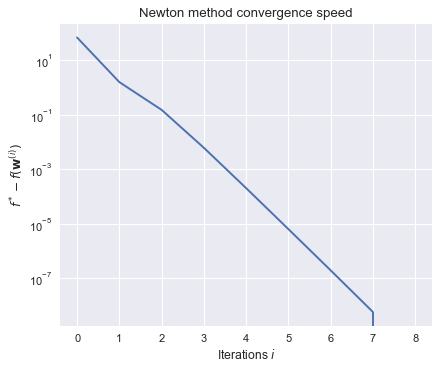

In [123]:
fig = plt.figure(dpi=80)
plt.plot(value_iters[-1]-value_iters)
plt.xlabel("Iterations $i$")
plt.ylabel("$f^* - f(\\mathbf{w}^{(i)})$")
plt.title("Newton method convergence speed")
plt.yscale('log');

In [124]:
fig.savefig('images/logistic-newton-convergence.pdf')

In [125]:
def logistic_prob(x, w):
    xaug = np.ones(3)
    xaug[1:] = x
    sig = expit(w @ xaug)
    return sig

In [129]:
proba_grid = np.array([
    logistic_prob(x, w_opt)
    for x in grid_points_
])

proba_grid = proba_grid.reshape(*xg.shape)

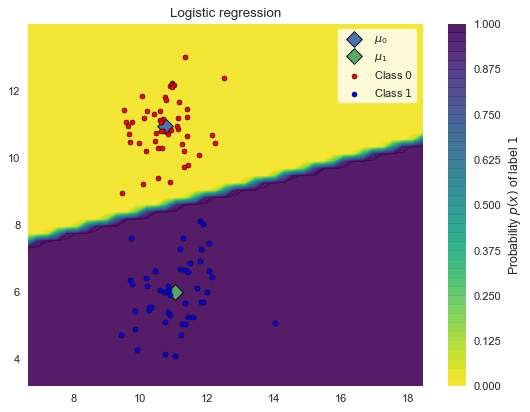

In [136]:
fig = plt.figure(figsize=(8, 6), dpi=80)

cf_ = plt.contourf(xg, yg, proba_grid, levels=40,
                   zorder=-1, alpha=0.9,
                   cmap=cm.viridis_r)


## Add the class centroids
for i, mu in enumerate(mus_):
    plt.scatter(*mu, s=100, marker='D',
                edgecolors='k', linewidths=.8,
                label="$\\mu_{%d}$" % i)

plt.scatter(*X_data[y_data==0].T, s=20, edgecolors='k',
            c='r', linewidths=.5, label="Class $0$")

plt.scatter(*X_data[y_data==1].T, s=20, edgecolors='k',
            c='b', linewidths=.5, label="Class $1$")

legend_ = plt.legend(frameon=1)
frame_ = legend_.get_frame()
frame_.set_color('white')

plt.grid(False)
plt.axis('scaled')

plt.xlim(*xlims_)
plt.ylim(*ylims_)

plt.title("Logistic regression")

cbar_ = fig.colorbar(cf_)
cbar_.set_label("Probability $p(x)$ of label $1$");

In [138]:
fig.savefig('images/logisticreg-result.pdf')